# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import matplotlib.pyplot as plt


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Data Cleaning
## 1.1. Porfolio
- Update the name of the id column to offer_id.
- Divide the channels into a number of columns.
- Offer_type should be split across different columns.


In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
# Update the name of the id column to offer_id.
portfolio.rename(columns={'id':'offer_id'},inplace=True)

In [6]:
# Divide the channels into a number of columns.
channel_dummies = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack(), prefix='channel').sum(level=0)
portfolio = pd.concat([portfolio,channel_dummies],axis=1)
portfolio.drop(columns=['channels'],inplace=True)

In [7]:
# Offer_type should be split across different columns.
# offer_dummies = pd.get_dummies(portfolio['offer_type'], prefix='offer_type')
# portfolio = pd.concat([portfolio.drop(columns=['offer_type']),offer_dummies], axis=1)

# Result:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


## 1.2. Profile
- Replace the name "id" with "customer_id".
- Fix the date.
- Irregular ages in the "age" column.
- In the gender and income columns, there are 17,000 - 14,825 = 2,175 missing values.

In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [10]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [11]:
# Replace the name "id" with "customer_id".

profile.rename(columns={'id':'customer_id'},inplace=True)

In [12]:
# Fix the date.
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: pd.to_datetime(str(x),format='%Y%m%d'))

In [13]:
# Handle missing values in "gender" column.
gender_dummies = pd.get_dummies(profile['gender'],prefix='gender')
profile = pd.concat([profile.drop(columns=['gender']),gender_dummies],axis=1)

In [14]:
# Some customers who has the irregular ages. Take them out of the concern by adding a new column - "valid"
ages = profile['age'].unique()
perct_old_ages = profile['age'][profile['age'] > 100].count()/profile['age'].count() * 100

print('''
Unique ages in the df: {},
% customers who has the age > 100: {} %
'''.format(ages, round(perct_old_ages,2)))

profile['valid'] = profile['age'].apply(lambda x: 1 if x <= 100 else 0)

# Result:
profile.head()


## TO_DO: Not handling the missing values in "income" columns????????


Unique ages in the df: [118  55  75  68  65  58  61  26  62  49  57  40  64  78  42  56  33  46
  59  67  53  22  96  69  20  45  54  39  41  79  66  29  44  63  36  76
  77  30  51  27  73  74  70  89  50  90  60  19  72  52  18  71  83  43
  47  32  38  34  85  48  35  82  21  24  81  25  37  23 100  28  84  80
  87  86  94  31  88  95  93  91  92  98 101  97  99],
% customers who has the age > 100: 12.82 %



,age,became_member_on,customer_id,income,gender_F,gender_M,gender_O,valid
0,118,2017-02-12,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,0,0,0
1,55,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,1
2,118,2018-07-12,38fe809add3b4fcf9315a9694bb96ff5,NaN,0,0,0,0
3,75,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,1
4,118,2017-08-04,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,0,0


In [15]:
# profile_clean = profile.copy()
# # Transform date from int to datetime
# date = lambda x: pd.to_datetime(str(x), format='%Y%m%d')
# profile_clean.became_member_on = profile_clean.became_member_on.apply(date)
# # Create column that separates customers with valida data
# profile_clean['valid'] = (profile_clean.age != 118).astype(int)
# # Change the name of id column to customer_id
# profile_clean.rename(columns={'id':'customer_id'}, inplace=True)
# # Create dummy columns for the gender column
# dummy_gender = pd.get_dummies(profile_clean.gender, prefix="gender")
# profile_clean = pd.concat([profile_clean, dummy_gender], axis=1, sort=False)
# return profile_clean

## 1.3. Transcript
- Rename the "person" column to "customer_id".
- Get dummies for "event" column.
- Unlist the values in "value" column.



In [16]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [17]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [18]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [19]:
# Rename the "person" column to "customer_id".
transcript.rename(columns={'person':'customer_id'},inplace=True)

# Get dummies for "event" column.
transcript['event'] = transcript['event'].apply(lambda x: x.replace(' ','_'))
event_dummies = pd.get_dummies(transcript['event'], prefix='event')
transcript = pd.concat([transcript.drop(columns=['event']), event_dummies], axis=1)

# Unlist the values in "value" column.
transcript['offer_id'] = [list(x.values())[0]  if (list(x.keys())[0] in ['offer_id', 'offer id']) else np.nan for x in transcript['value']]
transcript['amount'] = [list(x.values())[0]  if (list(x.keys())[0] in ['amount']) else np.nan for x in transcript['value']]
transcript.drop(columns=['value'],inplace=True)


# transcript['event'].unique()
transcript.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


# 1.4. Merge datasets

In [20]:
df = pd.merge(transcript, profile, on='customer_id', how="left")
df = pd.merge(df, portfolio, on='offer_id', how="left")
df.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,age,became_member_on,...,gender_O,valid,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,...,0,1,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,118,2017-08-04,...,0,0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,68,2018-04-26,...,0,1,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,118,2017-09-25,...,0,0,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,118,2017-10-02,...,0,0,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [21]:
df['offer_id'].unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837', nan], dtype=object)

In [22]:
# Simplify the offer_id:
offer_list = {'ae264e3637204a6fb9bb56bc8210ddfd': 'B1',
                '4d5c57ea9a6940dd891ad53e9dbe8da0': 'B2',
                '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'B3',
                'f19421c1d4aa40978ebb69ca19b0e20d': 'B4',
                '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'D1',
                '2298d6c36e964ae4a3e7e9706d1fb8c2': 'D2',
                'fafdcd668e3743c1bb461111dcafc2a4': 'D3',
                '2906b810c7d4411798c6938adc9daaa5': 'D4',
                '3f207df678b143eea3cee63160fa8bed': 'I1',
                '5a8bc65990b245e5a138643cd4eb9837': 'I2'}

df['offer_id'] = df['offer_id'].apply(lambda x: offer_list[x] if (x in offer_list.keys()) else x)

df.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,age,became_member_on,...,gender_O,valid,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,B3,NaN,75,2017-05-09,...,0,1,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,D1,NaN,118,2017-08-04,...,0,0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,D4,NaN,68,2018-04-26,...,0,1,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,D3,NaN,118,2017-09-25,...,0,0,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,B2,NaN,118,2017-10-02,...,0,0,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


# 2. Analysis


## 2.1. Age & Income
- There is an outlier. The presence of people over the age of 115 is unusually high.
- The average user is in their middle years, between the ages of 50 and 62.
- Average income user is middle income group ie. 65000-70000

In [23]:
def addlabels(x,y,rotation='horizontal'):
    '''
    INPUT:
    - x: an array of x labels
    - y: an array of y values
    - rotation: the default is 'horizontal', could be changed to 'vertical' or a number of degree.
    OUTPUT: the label values attached in each bar column.
    '''
    for i in range(len(x)):
        plt.text(i,y[i]//2,y[i],horizontalalignment='center')

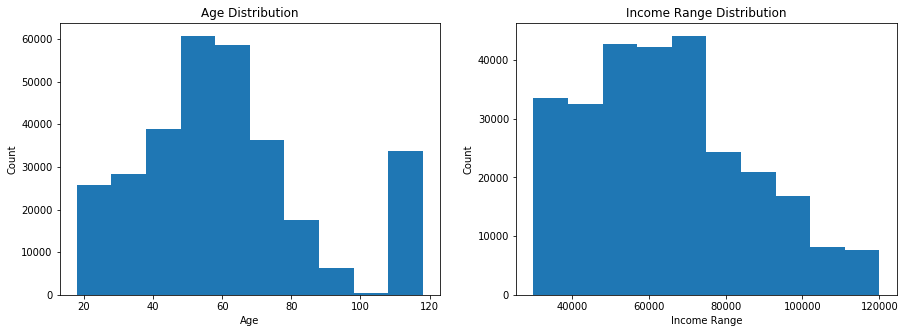

In [24]:
# Age & Income Distribution
plt.subplot(121)
df['age'].plot(kind='hist',figsize=(10, 5))
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution');


plt.subplot(122)
df['income'].plot(kind='hist',figsize=(15, 5))
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Range Distribution');



## 2.2. Total Expense & #Transactions

In [25]:
customer_dict = dict()
trans = df[df['event_transaction'] == 1].groupby('customer_id')
customer_dict['total_expense'] = trans['amount'].sum()
customer_dict['total_trans'] = trans['amount'].count()


customer_df = pd.DataFrame.from_dict(customer_dict)
customer_df['customer_id'] = customer_df.index
customer_df = customer_df[['customer_id','total_expense','total_trans']]
customer_df.reset_index(level=0,drop=True,inplace=True)
gender_df = df[['customer_id','gender_M','gender_F','gender_O']].drop_duplicates()


customer_df = pd.merge(gender_df, customer_df, on='customer_id', how="left")
customer_df.head()

,customer_id,gender_M,gender_F,gender_O,total_expense,total_trans
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,159.27,7.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,0,4.65,3.0
2,e2127556f4f64592b11af22de27a7932,1,0,0,57.73,3.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,0,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,0,0.24,2.0


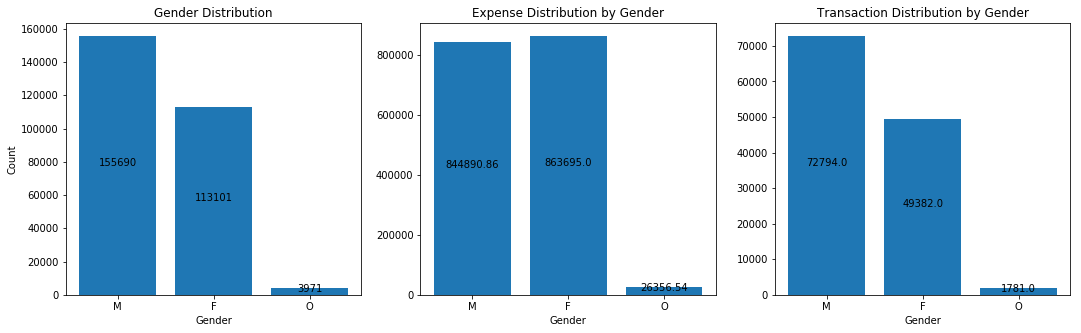

In [26]:
genders = ['M', 'F', 'O']
y_pos = np.arange(len(genders))

M_count = df['gender_M'].sum()
F_count = df['gender_F'].sum()
O_count = df['gender_O'].sum()
count_genders = [M_count, F_count, O_count]

M_expense = customer_df[customer_df['gender_M']==1]['total_expense'].sum()
F_expense = customer_df[customer_df['gender_F']==1]['total_expense'].sum()
O_expense = customer_df[customer_df['gender_O']==1]['total_expense'].sum()

M_trans = customer_df[customer_df['gender_M']==1]['total_trans'].sum()
F_trans = customer_df[customer_df['gender_F']==1]['total_trans'].sum()
O_trans = customer_df[customer_df['gender_O']==1]['total_trans'].sum()


f, ax = plt.subplots(figsize=(18,5))

plt.subplot(131)
plt.bar(y_pos, count_genders, align='center')
plt.xticks(y_pos, genders)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
addlabels(genders,count_genders,rotation='horizontal');

plt.subplot(132)
plt.bar(y_pos, [M_expense,F_expense,O_expense], align='center')
plt.xticks(y_pos, genders)
plt.xlabel('Gender')
plt.title('Expense Distribution by Gender')
addlabels(genders,np.array([M_expense,F_expense,O_expense]),rotation='horizontal');

plt.subplot(133)
plt.bar(y_pos, [M_trans,F_trans,O_trans], align='center')
plt.xticks(y_pos, genders)
plt.xlabel('Gender')
plt.title('Transaction Distribution by Gender')
addlabels(genders,np.array([M_trans,F_trans,O_trans]),rotation='horizontal');


Males account for more than half of all users. It makes sense when males have significantly larger total expenses and transactions than the other genders.

## 2.3. Offer

In [27]:
print('''
Let's look at the overall amount of money spent on the experiment. 
The experiment lasted over {} days, and {} occurrences were recorded in all.
'''.format(round(df['time'].max()/24, 0), df.shape[0])
     )


Let's look at the overall amount of money spent on the experiment. 
The experiment lasted over 30.0 days, and 306534 occurrences were recorded in all.



Each offer was almost identical in terms of the number of times it was received. 
The offers were most likely distributed using a uniform distribution by the data simulator.

''

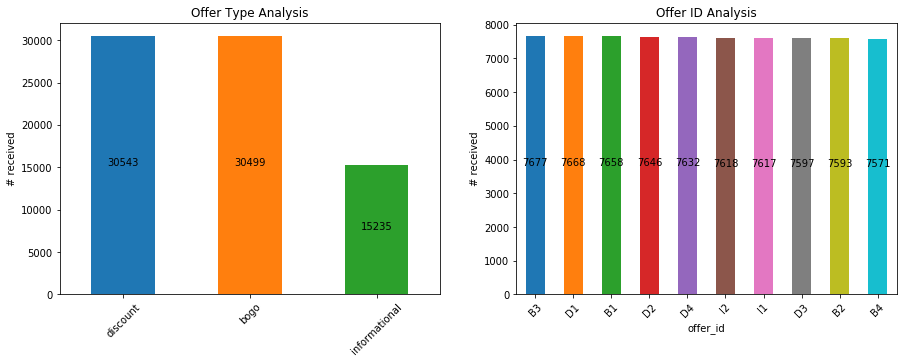

In [28]:
# Offer Type Analysis & Offer ID Analysis
plt.subplot(121)
df[df['event_offer_received'] == 1]['offer_type'].value_counts().plot(kind='bar', rot=45, figsize=(15,5))
plt.title('Offer Type Analysis')
addlabels(df[df['event_offer_received'] == 1]['offer_type'].value_counts().index, df[df['event_offer_received'] == 1]['offer_type'].value_counts().values)
plt.ylabel('# received');

plt.subplot(122)
df[df['event_offer_received'] == 1]['offer_id'].value_counts().plot(kind='bar', rot=45)
plt.title('Offer ID Analysis')
plt.xlabel('offer_id')
plt.ylabel('# received')
addlabels(df[df['event_offer_received'] == 1]['offer_id'].value_counts().index, df[df['event_offer_received'] == 1]['offer_id'].value_counts().values)
;

The distribution of offers received by customers is depicted in the graph above. We've received 30,000 discount and bogo offers, as well as 15,000 informational offers. Because there are only two informational offers and four discounts and four bogos, the latter offer is half the price of the others. Furthermore, each offer has been received by around 7,600 people. This is significant because the simulated data is not biassed in favour of any one offer; each consumer has the same chances of receiving any offer.